In [2]:
import pandas as pd
import itertools
import seaborn as sns
from db import get_df, Database
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_auc_score, roc_curve

%matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats


set_matplotlib_formats('svg')

pd.set_option('display.max_rows', None)

__pcaps = {}

def get_pcaps(slot_h=1.):
    if slot_h in __pcaps:
        return __pcaps[slot_h]
    
    db = Database()

    DF_FP = get_df(db, 'normal', None, True, 'nx', slot_h=slot_h).iloc[0:int(8/slot_h)]

    dfs = {
        'healthy': DF_FP,
        'caphaw': get_df(db, 'caphaw', 54, True, 'nx'),
        'zbot': get_df(db, 'zbot', 46, True, 'nx'),
        'simda': get_df(db, 'simda', 58, True, 'nx'),
        'unknown': get_df(db, 'unknown', 57, True, 'nx'),
    }
    return dfs


In [3]:

def simulate_pcaps(dfs, slot_h, window_slots, sigma_fp_ratio=1.0, mus_ratios=[0.5,1.0,1.5]):

    res = []
    for mw in dfs:
        if mw == 'healthy':
            continue
        df_tp = dfs[mw]
        skipped_all = 0
        skipped_any = 0
        for w in range(0, int(24*30/slot_h)):
            tps = df_tp.iloc[w:w + window_slots]['pp'].reset_index(drop=True)

            if tps.shape[0] < window_slots:
                break

            for mus_ratio in mus_ratios:
                mu_fp = tps.mean() / mus_ratio
                sigma_fp = mu_fp * sigma_fp_ratio

                fps = np.random.normal(mu_fp, sigma_fp, tps.shape[0])

                labels = tps > 0

                if labels.all() or labels.any() == False:
                    skipped_all += labels.all()
                    skipped_any += labels.any() == False
                    continue

                fpr, tpr, thresholds = roc_curve(labels, (fps + tps), drop_intermediate=False)
                roc_auc = auc(fpr, tpr)

                mask = fpr < 0.01
                pAUCs_001 = roc_auc_score(labels, (fps + tps), max_fpr=0.01)

                try:
                    pAUC_001 = auc(fpr[mask], tpr[mask])
                except:
                    pAUC_001 = np.nan
                    pass

                res.append([
                    mw,
                    w,
                    mus_ratio,
                    sigma_fp_ratio,
                    tps.std() / tps.mean(),
                    mu_fp,
                    sigma_fp,
                    tps.mean(),
                    tps.std(),
                    fpr,
                    tpr,
                    roc_auc,
                    pAUCs_001,
                    pAUC_001
                ])
                pass
            pass
        pass

    DF = pd.DataFrame(res, columns=[
        'mw',
        'w',
        'mus_ratio',
        'sigma_fp_ratio',
        'sigma_tp_ratio',
        'mu_fp',
        'sigma_fp',
        'mu_tp',
        'sigma_tp',
        'fpr',
        'tpr',
        'roc_auc',
        'pAUCs_001',
        'pAUC_001'
    ])

    return DF


In [4]:

slot_h = 1
pcaps = get_pcaps(slot_h)
mus_ratios = [0.5,1.0,1.5]
window_slots = 16
N=1
linspace_num_s = [3]
sigma_fp_ratios = [0.1, 0.5, 1, 2, 4]
dfs = []
for repetition in range(N):
    for sigma_fp_ratio in sigma_fp_ratios:
        df = simulate_pcaps(pcaps, slot_h, window_slots, sigma_fp_ratio=sigma_fp_ratio, mus_ratios=mus_ratios)
        dfs.append(df)
        pass

df = pd.concat(dfs, axis=0)

df.to_pickle(f'DF__sim{N}.csv')

In [5]:
df = pd.read_pickle('DF__sim1.csv')

intervals = 10

df['mus_ratio_cat'] = pd.CategoricalIndex(df['mus_ratio'])

df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=5)
df['sigma_tp_ratio_mid'] = df['sigma_tp_ratio_cat'].apply(lambda x: x.left).astype(np.float64)
# df['sigma_tp_ratio_cat'] = pd.cut(df['sigma_tp_ratio'], bins=pd.IntervalIndex([ pd.Interval(b[0], b[1], closed='right') for b in bins ]))

df['fpr'] = df['fpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))
df['tpr'] = df['tpr'].apply(lambda s: pd.cut(s, bins=pd.IntervalIndex.from_breaks([-.001] + list(map(lambda x: x/intervals, range(1,intervals + 1))), closed='right')))

df = df.explode(['fpr','tpr'])


df.fpr = df.fpr.apply(lambda x: x.left)
df.tpr = df.tpr.apply(lambda x: x.left)

for mw in df.mw.drop_duplicates():
    g = sns.relplot(df[df.mw == mw],
                    x='fpr', y='tpr',
                    hue='sigma_tp_ratio_mid',
                    row='mus_ratio_cat', col='sigma_fp_ratio',
                    errorbar=('ci', 0.9),
                    kind='line', markers=False, dashes=False,
                    height=3,
                    facet_kws=dict(sharey=False, sharex=False))

    rows = g.axes.shape[0]
    cols = g.axes.shape[1]

    [ g.axes[i,0].set_ylabel(g.axes[i,0].title.get_text().split('|')[0] + '\ntpr') for i in range(rows) ]
    [ g.axes[0,j].set_title(g.axes[0,j].title.get_text().split('|')[1], size='medium') for j in range(cols) ]
    [ g.axes[i,j].set_title('') for i in range(1,rows) for j in range(cols) ]
    [ g.axes[i,j].grid(True, axis='both', linestyle='--', color='lightgray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_yticks(list(map(lambda x: x/5, range(6)))) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_xticks(list(map(lambda x: x/20, range(6)))) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].tick_params(axis="x", direction="in", pad=-12, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].tick_params(axis="y", direction="in", labeltop=True, pad=-20, labelsize='small', labelcolor='gray') for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_ylim(-0.1, 1.05) for i in range(rows) for j in range(cols) ]
    [ g.axes[i,j].set_xlim(-0.04, 0.26) for i in range(rows) for j in range(cols) ]

    pass

/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_45488/872068886.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df[['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin']).mean().reset_index()
/var/folders/4s/h7p_rb6j4ts7ml0z0l5qj_x00000gn/T/ipykernel_45488/872068886.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfg = df[['mw', 'mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['mw', 'mus_ratio', 'sigma_fp_ratio',  'sigma_tp_ratio_bin']).mean().reset_index()


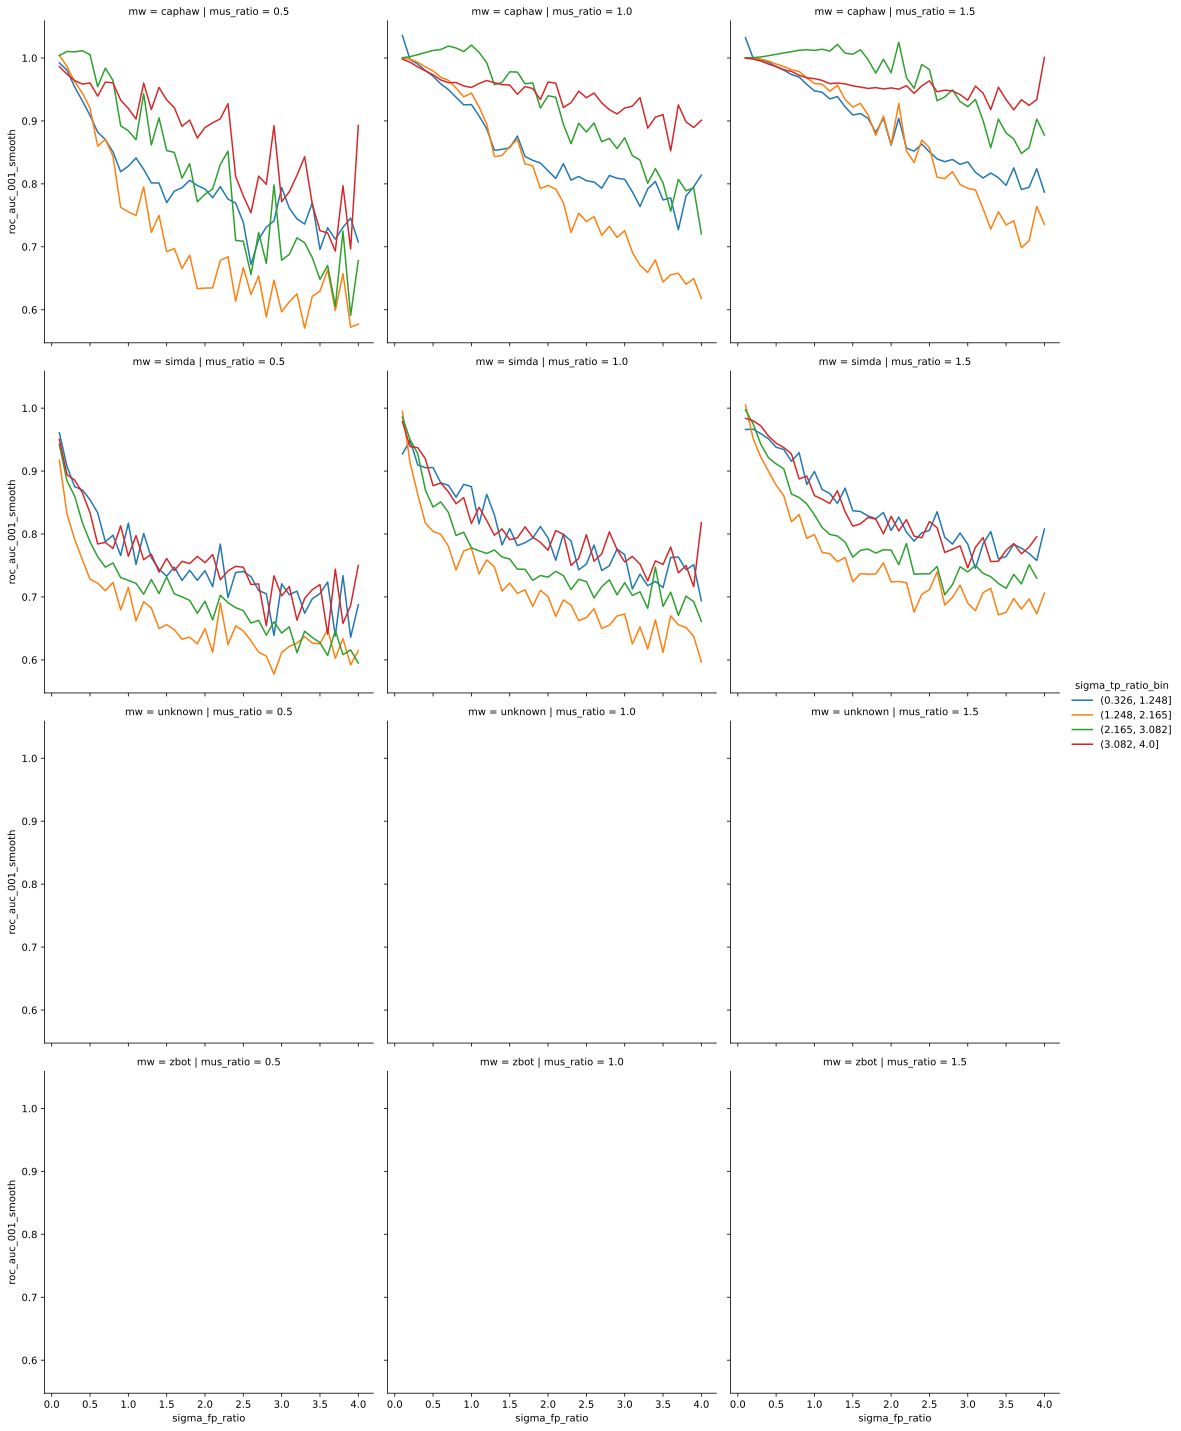

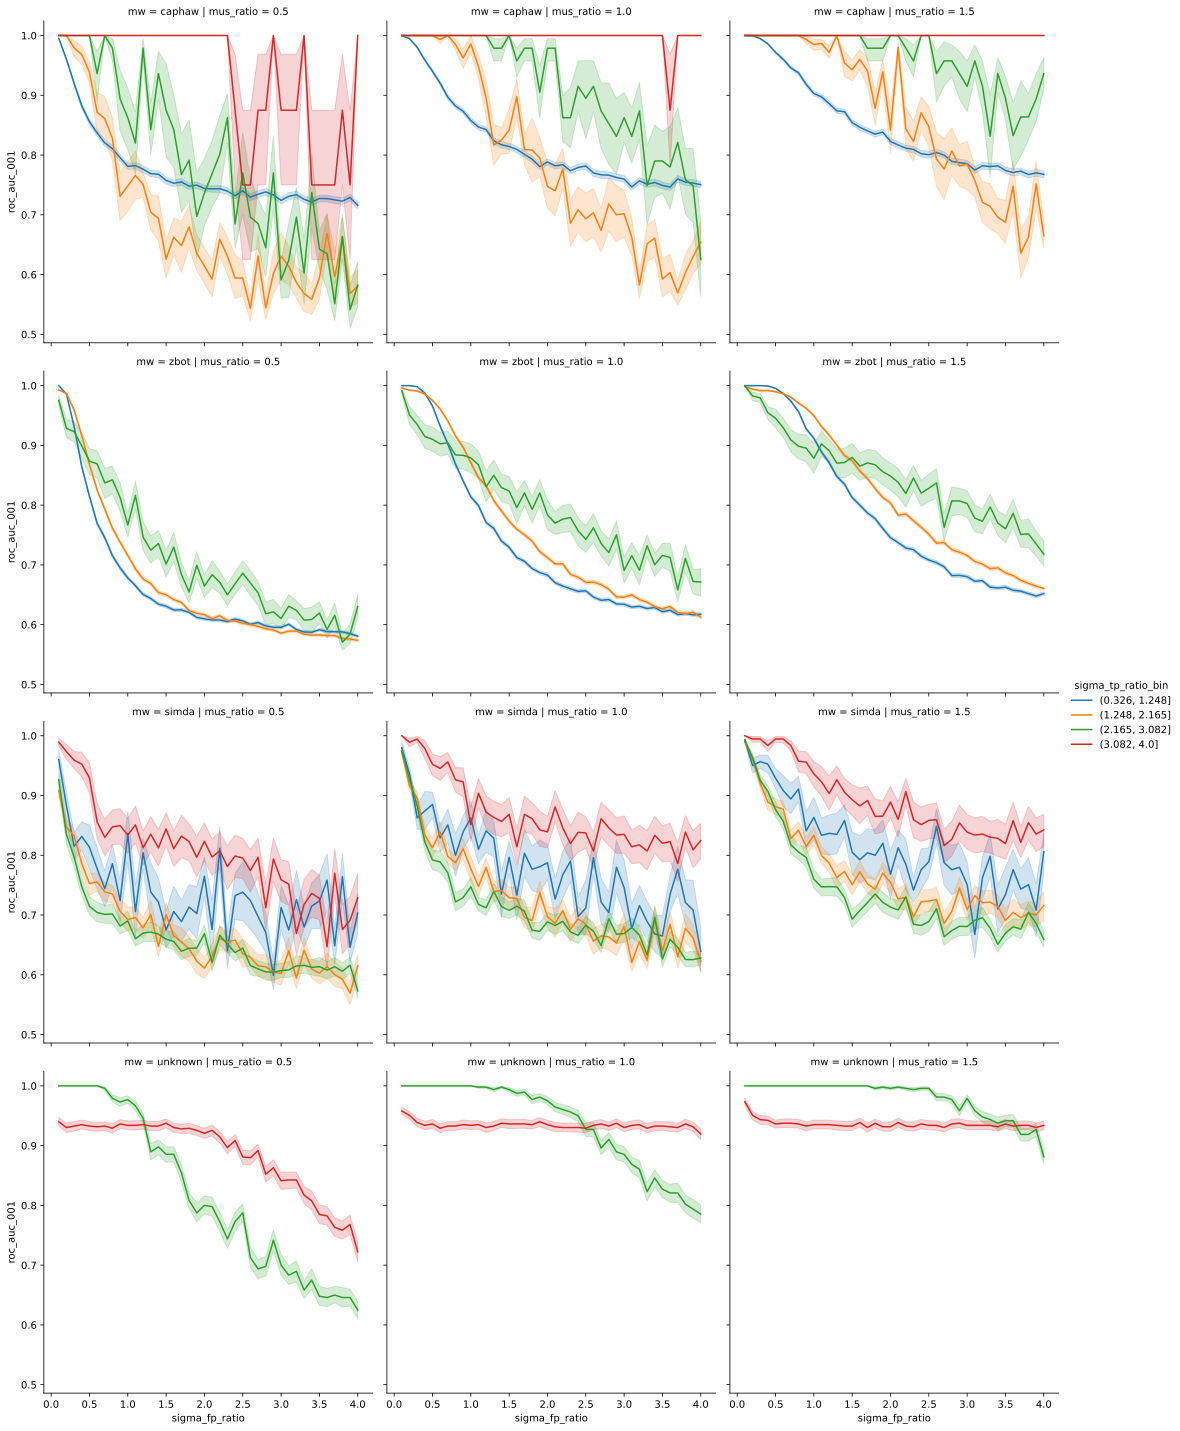

In [5]:

df = pd.read_csv('DF_40.csv', index_col=None)

ii = pd.IntervalIndex.from_breaks([0.5, 1, 5, 10, 100], closed='right')

# df['mus_ratio'] = pd.cut(df['mus_ratio'], bins=ii)

tmp = df['sigma_tp_ratio'].copy()

df['sigma_tp_ratio_bin'] = pd.cut(tmp, 4, duplicates='drop')
df['sigma_tp_ratio_qcut_bin'] = pd.qcut(tmp, 4, duplicates='drop')

# # df['mus_ratio_bin'] = pd.qcut(df['mus_ratio'], 6, duplicates='drop')
# pivot_table = df.pivot_table(index='sigma_tp_ratio_bin', columns='mus_ratio_bin', values='fpr_001', aggfunc='count')
# print(pivot_table)


# df = df.melt(id_vars=['mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio','sigma_tp_ratio_qcut'], value_vars=['fpr_001', 'tpr_001'])

dfg = df[['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['sigma_fp_ratio', 'mus_ratio', 'sigma_tp_ratio_bin']).mean().reset_index()


# df = df[df.mus_ratio_bin in []]

# df = df[df['mus_ratio'].apply(lambda x: x in df.mus_ratio_bin.cat.categories[2:])]

# sns.relplot(dfg, x='sigma_fp_ratio', y='roc_auc_001', kind='line',
# hue='sigma_tp_ratio_bin', col='mus_ratio_bin')

if True:
    from scipy.signal import savgol_filter
    import numpy as np
    import matplotlib.pyplot as plt

    # Dati di esempio
    x = np.linspace(0, 10, 100)
    y = np.sin(x) + np.random.normal(0, 0.5, size=x.shape)

    dfg = df[['mw', 'mus_ratio', 'sigma_fp_ratio', 'sigma_tp_ratio_bin', 'roc_auc_001']].groupby(['mw', 'mus_ratio', 'sigma_fp_ratio',  'sigma_tp_ratio_bin']).mean().reset_index()

    # Applica il filtro di Savitzky-Golay
    dfg['roc_auc_001_smooth'] = savgol_filter(dfg['roc_auc_001'], window_length=5, polyorder=2)

    sns.relplot(dfg, x='sigma_fp_ratio', y='roc_auc_001_smooth', kind='line', hue='sigma_tp_ratio_bin', col='mus_ratio', row='mw')
    
    pass

__df = pd.concat([df.copy() for _ in range(4)], axis=0)

sns.relplot(__df, x='sigma_fp_ratio', y='roc_auc_001', kind='line', hue='sigma_tp_ratio_bin', col='mus_ratio', row='mw')


# sns.relplot(df[df['variable'] == 'tpr_001'], x='sigma_fp_ratio', y='value',
# kind='line', hue='sigma_tp_ratio_qcut', col='mus_ratio')



In [ ]:

df = DF.melt(id_vars=['mw', 'th_001_range', 'fpr_001', 'tpr_001', 'sigma_fp_ratio', 'sigma_tp_ratio', 'roc_auc', 'roc_auc_001'], value_vars=['fpr','tpr'])#.head(50)

_col='mw'

xmax = 2.0
xstep = 0.5
xticks = list(map(lambda x: xstep * x, range(int((xmax + 0.1)/xstep)))) + [xmax]

df = DF.melt(id_vars=['mw', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['roc_auc', 'roc_auc_001'])
g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]

g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col,
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)
g.set(xlim=(0.1, xmax), xticks=xticks)
g.set(ylim=(0.5, 1.0), yticks=list(map(lambda x: 0.5 + 0.1 * x, range(5))))
[ ax.tick_params(axis='x', labelsize='small') for ax in g.axes[0,:]]



df = DF.melt(id_vars=['mw', 'sigma_fp_ratio', 'sigma_tp_ratio'], value_vars=['fpr', 'fpr_001', 'tpr', 'tpr_001'])




df['auc'] = (df['variable'].str.find('_001') >= 0).apply(lambda x: 'fpr < 0.01' if x else 'full')
df['variable'] = df['variable'].str[0:3]



g = sns.relplot(
    data=df, kind="line",
    x="sigma_fp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)



g = sns.relplot(
    data=df, kind="line",
    x="sigma_tp_ratio", y="value", hue='variable', col=_col, style='auc',
    facet_kws=dict(sharex=False),
    aspect=1,
    height=4
)


In [62]:
def neg_rp(mu, sigma):
    try:
        _r = pow(mu,2)/(pow(sigma,2) - mu)
        _p = mu/pow(sigma,2)
        # print(f'{_r > 0 and (_p >= 0 and _p <=1)}\tmu={mu}\tsimga={sigma}\t_r={_r}\t_p={_p}')
        return _r, _p
    except:
        return neg_rp(mu - 1, sigma)

res = []
for mu, sigma_ratio in itertools.product([5, 50, 100], map(lambda x: x/10 + 0.5, range(1,10))):
    sigma = mu*sigma_ratio
    _r, _p= neg_rp(mu, sigma)
    res.append([
        mu, sigma, sigma_ratio, _r, _p
    ])

df = pd.DataFrame(res, columns='mu,sigma,sigma_ratio,_r,_p'.split(','))
print(all(df['_r'] > 0), all(df['_p'].between(0,1, inclusive='both')))
display(df)

True True


,mu,sigma,sigma_ratio,_r,_p
0,5,3.0,0.6,6.250000,0.555556
1,5,3.5,0.7,3.448276,0.408163
2,5,4.0,0.8,2.272727,0.312500
3,5,4.5,0.9,1.639344,0.246914
4,5,5.0,1.0,1.250000,0.200000
5,5,5.5,1.1,0.990099,0.165289
6,5,6.0,1.2,0.806452,0.138889
7,5,6.5,1.3,0.671141,0.118343
8,5,7.0,1.4,0.568182,0.102041
9,50,30.0,0.6,2.941176,0.055556
